### Empirical evidence of CIP deviations

Let $S^i_t$ be the price of one USD in units of currency $i$ at time $t$. To hedge the exchange rate risk, carry traders can purchase forward contract. Parties who enter a forward contract $(i,t,\tau)$ agree to exchange currency $i$ to USD at a prespecified rate $F^i_{t,t+\tau}$ in $\tau$ years from $t$. By no arbitrage, 

$\dfrac{F^i_{t,t+\tau} (1+r^{US}_{t,t+\tau})}{S^i_t (1+r^i_{t,t+\tau})}  = 1$

or 

$\dfrac{F^i_{t,t+\tau} \exp(r^{US}_{t,t+\tau}-r^i_{t,t+\tau})}{S^i_t} = 1$ 

if we use the continuously-compounded interest rate.

Now we know the forward rate and spot exchange rate at any given time $t$ (here for monthly frequency), it is straightforward to construct the model-implied interest rate differential that makes CIP held. Take logs for CIP condition we have 

$ f^i_{t,t+\tau} - s^i_t = r^i_{t,t+\tau} -  r^{US}_{t,t+\tau}$ 

There are many choices for the risk-less interest rates of USD. Government debt of various maturities can serve the purpose for a carry trade. However, the rate of return on long-term risk-less securities are affected by many factors, including liquidity premium, interest rate risk, inflation risk, and term premium. So for practitioners they usually implement carry trade strategies using interest rate swaps. On the other hand, the existence of time-varying predictable bond premium also makes it possible for speculators to profit from carry trade by holding bonds. 

Excess US bank reserves can also serve the role for carry trade. The central bank of US pays interests on excess bank reserves to all those qualifying depository institutions, including foreign banks. In theory, the excess bank reserve can be viewed as a bond with infinite maturity and floating interest rate. 

In the computation we will use the following way to transform annualized rate to continously-compounding rate:

$r^i_{t,t+\tau} = \tau \log(1+r^{i,ann}_{t,t+1})$

In [1]:
import pandas as pd
from fredapi import Fred
import numpy as np

In [2]:
fx = pd.read_excel("CIPdata.xls", sheet_name = 'exchange rate', skiprows = 1).set_index(keys = 'Code')
del fx.index.name

# Forward rate JPY-USD
JPY_WMR = ['JAPAYE$', 'USJPYON', 'USJPYTN', 'USJPYWF', 'USJPY1F', 'USJPY2F', 'USJPY3F', 'USJPY6F', 'USJPY9F', 
          'USJPYYF', 'USJPY2Y', 'USJPY5Y']
JPYUSD_WMR = fx[JPY_WMR]
JPYUSD_WMR.tail()

# Forward rate CAD-USD
CAD_BB = ['BBCADSP', 'BBCAD1F', 'BBCAD2F', 'BBCAD3F', 'BBCAD6F', 'BBCADYF']
CAD_WMR = ['CNDOLL$','USCADON', 'USCADTN', 'USCADWF', 'USCAD1F', 'USCAD2F', 'USCAD3F', 'USCAD6F', 'USCAD9F', 
          'USCADYF', 'USCAD2Y', 'USCAD5Y']
CADUSD_BB = fx[CAD_BB]
CADUSD_WMR = fx[CAD_WMR]


# Interest rates: FRED
fred = Fred(api_key = '4784f4ab3b06abdc6c8cbdfa4c7825db')

# define variables of interest
tr_USD = ['IOER', 'EFFR','DGS1MO','DGS3MO','DGS6MO','DGS1','DGS2', 'DGS5', 'DGS10']
libor_USD = ['USDONTD156N','USD1WKD156N','USD1MTD156N','USD2MTD156N','USD3MTD156N','USD6MTD156N','USD12MD156N']
libor_JPY = ['JPYONTD156N','JPY1WKD156N','JPY1MTD156N','JPY2MTD156N','JPY3MTD156N','JPY6MTD156N','JPY12MD156N']
swap_USD = ['DSWP1', 'DSWP2', 'DSWP3', 'DSWP4', 'DSWP5', 'DSWP10', 'DSWP30']

tr_list = [fred.get_series(var).to_frame(name = var).interpolate()/100 for var in tr_USD]
libor_list_JPY = [fred.get_series(var).to_frame(name = var).interpolate()/100 for var in libor_JPY] 
libor_list_USD = [fred.get_series(var).to_frame(name = var).interpolate()/100 for var in libor_USD] 
swap_list_USD = [fred.get_series(var).to_frame(name = var).interpolate()/100 for var in swap_USD]

In [3]:
def CIP_implied_rates(df, cname):
    """
    Compute the implied interest rates of a currency i assuming that CIP holds
    """
    if cname == "CAD": 
        spot = "CNDOLL$"
    if cname == "JPY":
        spot = "JAPAYE$"
        
    df[cname + '3MO'] = df['US'+cname+'3F'] - df[spot] + np.log(1+df['DGS3MO'])/4
    df[cname + '6MO'] = df['US'+cname+'6F'] - df[spot] + np.log(1+df['DGS6MO'])/2
    df[cname + '1Y'] = df['US'+cname+'YF'] - df[spot] + np.log(1+df['DGS1'])
    df[cname + '2Y'] = df['US'+cname+'2Y'] - df[spot] + np.log(1+df['DGS2'])*2
    df[cname + '5Y'] = df['US'+cname+'5Y'] - df[spot] + np.log(1+df['DGS5'])*5
    
    return df

def _compute_basis(df, fwfreq, currency, spot, homerate, foreignrate, freq):
    return df['US'+currency+fwfreq]-df[spot]+np.log(1+df[homerate])/freq-np.log(1+df[foreignrate])/freq
    
def currency_basis(df, cname, refrate):
    """
    Compute the implied interest rates of a currency i assuming that CIP holds, based on LIBOR
    """
    outnames = ['1Wbasis', '1Mbasis', '3Mbasis', '6Mbasis', '1Ybasis']
    fwfreqs = ['WF','1F', '3F', '6F', 'YF']
    libor_suffix = ['1WKD156N', '1MTD156N', '3MTD156N', '6MTD156N', '12MD156N']
    freq = [52, 12, 4, 2, 1]
    
    if cname == "JPY":
        if refrate == 'libor':
            spot = "JAPAYE$"
            homerates = ['USD' + x for x in libor_suffix]
            foreignrates = [cname + x for x in libor_suffix]
            for i in range(len(outnames)):
                df[cname + outnames[i]] = _compute_basis(df, fwfreqs[i], cname, spot, homerates[i], foreignrates[i], freq[i])
        
        if refrate == "IOER":
            spot = "JAPAYE$"
            foreignrates = [cname + x for x in libor_suffix]
            for i in range(len(outnames)):
                df[cname + outnames[i]] = _compute_basis(df, fwfreqs[i], cname, spot, 'IOER', foreignrates[i], freq[i])
        
        if refrate == "EFFR":
            spot = "JAPAYE$"
            foreignrates = [cname + x for x in libor_suffix]
            for i in range(len(outnames)):
                df[cname + outnames[i]] = _compute_basis(df, fwfreqs[i], cname, spot, 'EFFR', foreignrates[i], freq[i])
        
            
            
    return df

def addcolumn(master, dflist):
    for df in dflist:
        master = master.merge(df, left_index = True, right_index = True, how = 'inner')
    return master

In [4]:
JPY = addcolumn(np.log(JPYUSD_WMR), tr_list[1:]) 
JPY = addcolumn(JPY, libor_list_JPY)
JPY = addcolumn(JPY, libor_list_USD)

JPY_swap = addcolumn(JPY, swap_list_USD)

### Invest in US Treasuries, assume CIP holds, plot the theoretical no-arbitrage risk-less rate in JPY

In [5]:
varlist = ['JPY3MO', 'JPY6MO', 'JPY1Y', 'JPY2Y', 'JPY5Y']
df1 = CIP_implied_rates( JPY , 'JPY')
df1 = df1[varlist] * 10000 # in basis points
fig = df1.plot(figsize = (20,10))
fig.grid()
fig.set_title('CIP-implied risk-less interest rates', fontsize = 18)

Text(0.5,1,'CIP-implied risk-less interest rates')

### LIBOR-based JPY-USD basis

Text(0.5,1,'LIBOR-based JPY-USD basis')

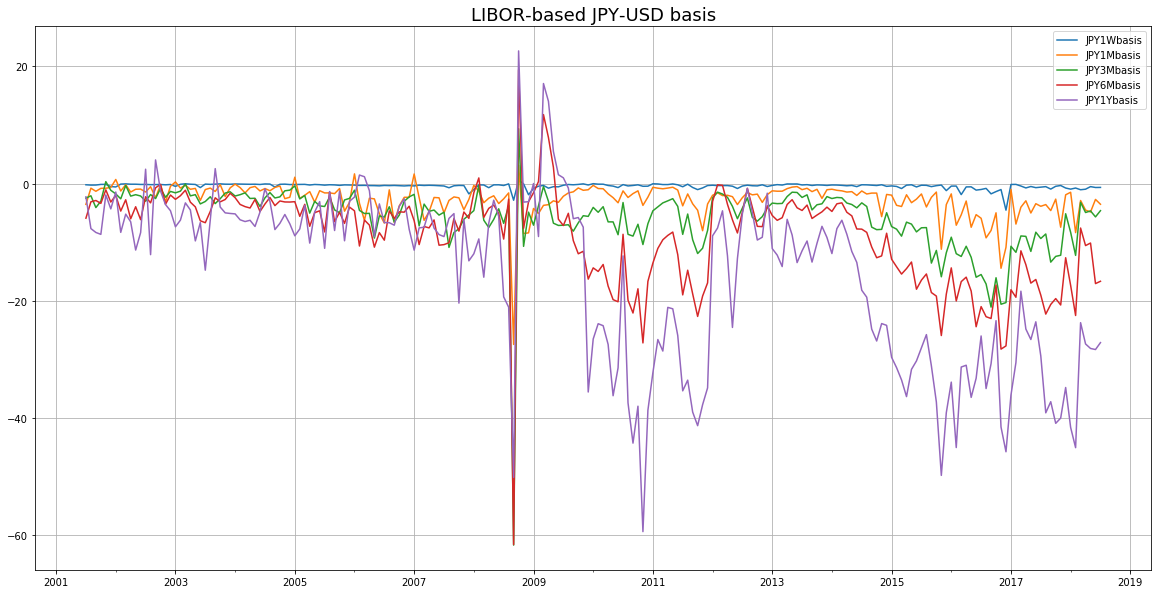

In [6]:
varlist = ['JPY1Wbasis', 'JPY1Mbasis', 'JPY3Mbasis', 'JPY6Mbasis', 'JPY1Ybasis']
JPYLIBOR = currency_basis(JPY, 'JPY', 'libor')
df = JPYLIBOR[varlist] * 10000
fig = df.plot(figsize = (20,10))
fig.grid()
fig.set_title('LIBOR-based JPY-USD basis', fontsize = 18)

In [ ]:
df['JPY3Mbasis']['2007-01-01':'2009-12-31'].mean() 

In [ ]:
df['JPY3Mbasis']['2010-01-01':'2016-12-31'].mean()

### IOER-based JPY-USD basis

In [ ]:
varlist = ['JPY1Wbasis', 'JPY1Mbasis', 'JPY3Mbasis', 'JPY6Mbasis', 'JPY1Ybasis', 'IOER-EFFR']
JPYIOER = addcolumn(JPY, [tr_list[0]])
JPYIOER['IOER-EFFR'] = JPYIOER['IOER']-JPYIOER['EFFR']
JPYIOER = currency_basis( JPYIOER , 'JPY', 'IOER')
df = JPYIOER[varlist] * 10000
fig = df.plot(figsize = (20,10))
fig.grid()
fig.set_title('IOER-based JPY-USD basis', fontsize = 18)

In [ ]:
JPYIOER['IOER-EFFR'].corr(JPYIOER['JPY3Mbasis'])

### Fed funds rate - based JPY-USD basis

In [ ]:
varlist = ['JPY1Wbasis', 'JPY1Mbasis', 'JPY3Mbasis', 'JPY6Mbasis', 'JPY1Ybasis']
JPY = addcolumn(JPY, [tr_list[0]])
JPYEFFR = currency_basis( JPY , 'JPY', 'EFFR')
df = JPYEFFR[varlist] * 10000
fig = df.plot(figsize = (20,10))
fig.grid()
fig.set_title('EFFR-based JPY-USD basis', fontsize = 18)